### Лабораторная работа №4. Основы нейронных сетей

## Измерение показаний датчиков для основных движений рук ##

1 здоровый испытуемый (мужчина, 22 года 
провел шесть хватаний по 100 раз каждое \
в течение 3 последовательных дней 
Измеренное время составляет 5 секунд\
(sEMG for Basic Hand movements).

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

![title](grasps_en.PNG)

### Подготовим данные и разделим выборку

In [10]:
import scipy.io
mat = scipy.io.loadmat('Database2/male_day_1.mat')
for key in ('__header__','__version__','__globals__'):
    mat.pop(key)


In [11]:
Kshape = 1
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for key, value in mat.items():
    data = mat[key]    
    df_temp=pd.DataFrame(data=data[0:,0:],
                         index=[i for i in range(data.shape[0])],
                         columns=[str(i) for i in range(data.shape[1])])
    df_temp['res'] = Kshape    
    if int(key[-1]) % 2 != 0:       
        df_train = df_train._append(df_temp,ignore_index=True)      
    else:
        df_test = df_test._append(df_temp,ignore_index=True)
        Kshape += 1
y_train = df_train['res']
x_train = df_train.drop(['res'],axis=1)
y_test = df_test['res']
x_test = df_test.drop(['res'],axis=1)

In [12]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,res
0,0.123201,0.199706,0.276211,0.072198,0.148703,0.123201,0.021195,0.123201,0.174205,0.123201,...,0.148703,0.199706,0.123201,0.046696,-0.004307,0.199706,0.123201,0.174205,0.403719,1
1,0.123201,0.225208,0.199706,0.174205,0.199706,0.021195,0.097700,0.123201,0.174205,0.199706,...,0.199706,0.199706,0.276211,0.225208,0.046696,-0.029808,-0.233821,0.021195,0.097700,1
2,0.174205,0.225208,0.123201,0.174205,0.021195,0.225208,0.097700,0.021195,0.531228,0.378218,...,0.148703,0.250710,0.225208,0.225208,0.123201,0.046696,0.097700,0.199706,-0.029808,1
3,0.148703,0.174205,0.021195,0.148703,0.072198,0.072198,0.352716,0.225208,0.199706,-0.284825,...,0.199706,0.046696,0.072198,0.174205,0.199706,0.301713,0.148703,0.199706,0.225208,1
4,0.250710,0.072198,0.123201,-0.386831,0.505726,0.454723,0.225208,-0.131815,-0.004307,-0.080812,...,0.021195,0.148703,-0.004307,0.174205,0.123201,0.352716,0.199706,0.225208,-0.080812,1


In [13]:
from sklearn.preprocessing import StandardScaler,PowerTransformer
scaler = StandardScaler()
scaler.fit(x_train)
sc_x_train = scaler.transform(x_train)

#### Потренерум модель и предскажем результат используя Perceptron

In [14]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import mean_squared_error, r2_score
clf = Perceptron() 
clf.fit(sc_x_train, y_train)
y_percep = clf.predict(x_test.values)
print(f'Mean Squared Error: {mean_squared_error(np.array(y_test), y_percep)}')
print(f'R^2 Score: {r2_score(np.array(y_test), y_percep)}')

Mean Squared Error: 5.493333333333333
R^2 Score: -0.8834285714285715


#### F1_score сбалансированный показатель ###
Интерпретируется как гармоническое среднее значение точности и полноты,\
где оценка F1 достигает своего лучшего значения при 1, а худшего — при 0

In [15]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_percep, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.11574725709268559


#### Изменим параметры Perceptron 

In [17]:
clf = Perceptron(penalty='elasticnet', eta0=0.0001)
clf.fit(x_train, y_train)
y_percep = clf.predict(x_test)
print(f'Mean Squared Error: {mean_squared_error(np.array(y_test), y_percep)}')
print(f'R^2 Score: {r2_score(np.array(y_test), y_percep)}')
f1 = f1_score(y_test, y_percep, average='weighted')
print(f'F1 Score: {f1}')

Mean Squared Error: 5.183333333333334
R^2 Score: -0.7771428571428571
F1 Score: 0.20796458920949


#### Рассмотрим данные построчно

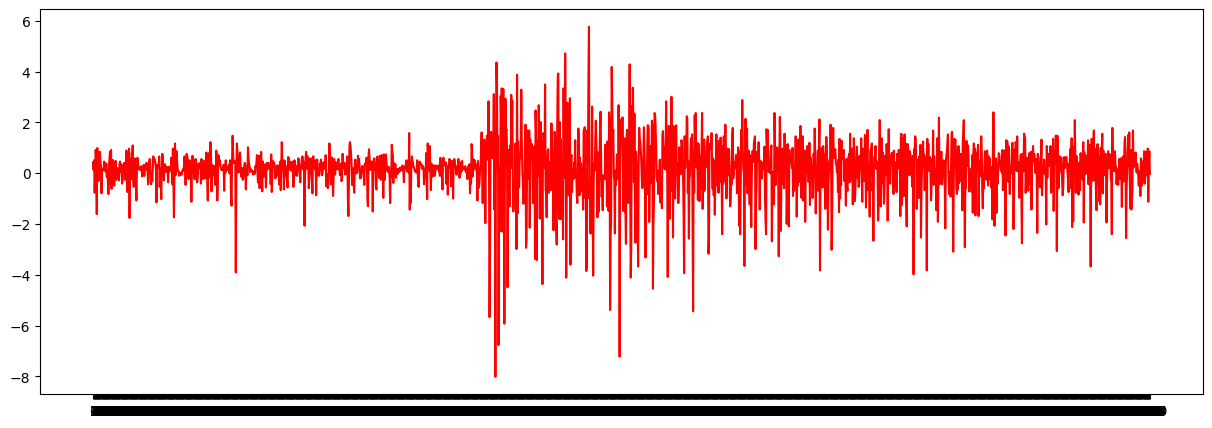

In [18]:
plt.rcParams['figure.figsize'] = [15,5]
plt.plot(x_test.iloc[1][:2000],'r')
plt.show()

### Используем методы оптимизации L-BFGS-B, sgd и adam

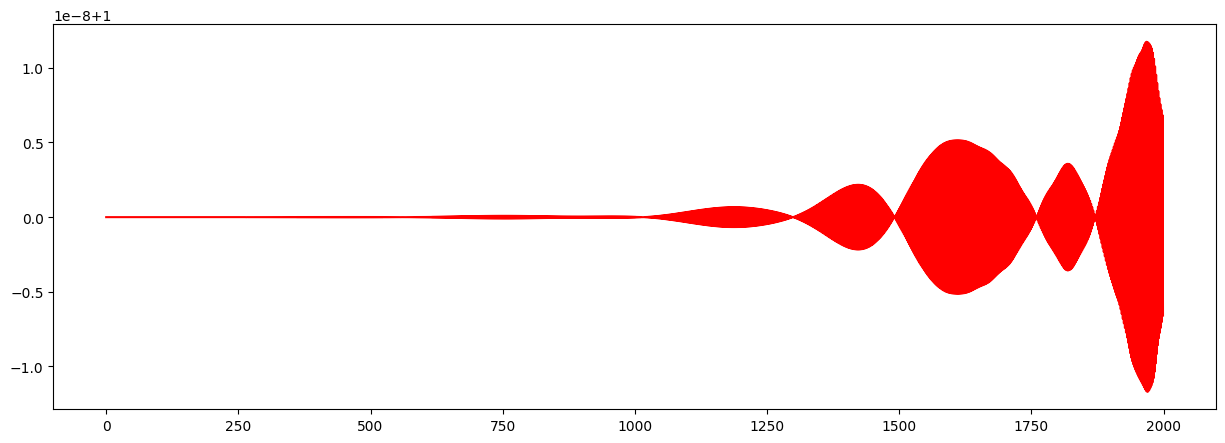

In [19]:
from scipy.optimize import minimize, rosen, rosen_der
res = minimize(rosen, x_test.iloc[1], method='L-BFGS-B', jac=rosen_der,
               options={'gtol': 1e-6, 'disp': True})
plt.plot(res.x[:2000],'r')
plt.show()

#### SGD

In [20]:
import tensorflow as tf

In [21]:
from tensorflow import keras
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[2500])])

In [22]:
model.compile(optimizer='sgd', loss='mean_squared_error')

In [23]:
model.fit(x_train, y_train, epochs=20,verbose=0)

In [24]:
y_preds = model.predict(x_test)

19/19 [==============================] - 0s 2ms/step


In [25]:
y_round_pr = np.round(y_preds)

In [26]:
f1 = f1_score(y_test, y_round_pr, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.1799014147288627


### Adam

In [27]:
model.compile(optimizer='adam', loss='Poisson') 
model.fit(x_train, y_train, epochs=20,verbose=0)
adam_y_preds = model.predict(x_test)
adam_y = np.round(adam_y_preds)
f1 = f1_score(y_test, adam_y, average='weighted')
print(f'F1 Score: {f1}')

19/19 [==============================] - 0s 2ms/step
F1 Score: 0.13685836626845402


## MLPClassifier ##

In [78]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1).fit(x_train, y_train)
y_percep = clf.predict(x_test)
print(f'Mean Squared Error: {mean_squared_error(np.array(y_test), y_percep)}')
print(f'R^2 Score: {r2_score(np.array(y_test), y_percep)}')
f1 = f1_score(y_test, y_round_pr, average='weighted')
print(f'F1 Score: {f1}')

Mean Squared Error: 5.746666666666667
R^2 Score: -0.9702857142857142
F1 Score: 0.1799014147288627
